<h2>Отчет по Лабоработной работе №1</h2>
 
Логи stderr в файле logs

Формат:

    n = <размер> 
    timeSimple: <time> 
    timeBlock: <time> 
    timeSwapped: <time> 


In [1]:
def parse_logs(path='logs'): 
    results = list()
    n = None
    for line in open(path): 
        if 'n = ' in line:
            n = int(line.split('=')[1].strip())
            results.append((n, dict()))
        else:
            alg, time = line.split(':')
            results[-1][1][alg[4:]] = float(time.strip())
    return results

results = parse_logs()

<h3> Визуализируем: </h3>

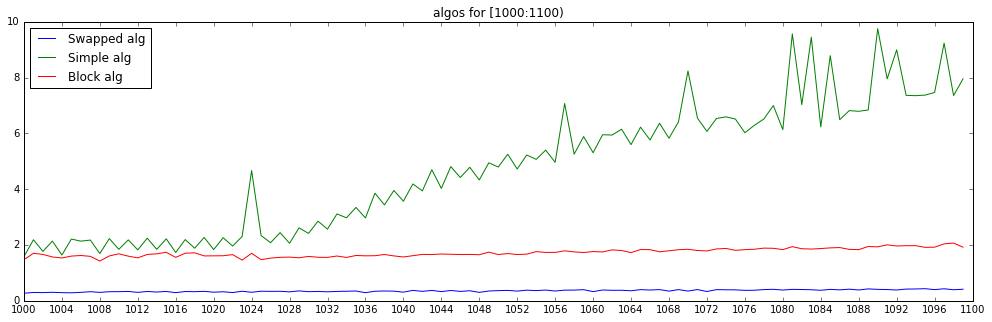

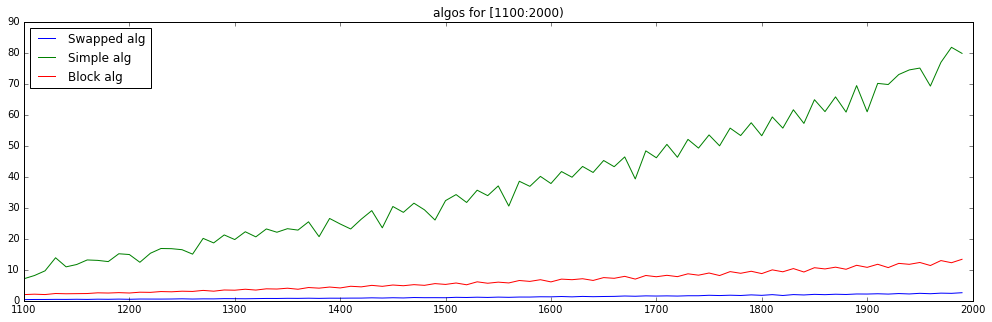

In [5]:
%matplotlib inline
from matplotlib import pyplot

def draw(results):
    algos = results[0][1].keys() 
        
    n_range = [result[0] for result in results]
    time_ranges = [[result[1][alg] for result in results] for alg in algos]

    ax = pyplot.figure(figsize=(17,5), dpi=100).add_subplot(111)  
    for time_range in time_ranges:
        ax.plot(n_range[:100], time_range[:100]) 
    ax.legend(['{} alg'.format(alg) for alg in algos], loc='upper left')
    ax.set_title('algos for [1000:1100)')
    min_x, max_x = ax.get_xlim()
    ax.set_xticks(range(int(min_x), int(round(max_x))+1, 4))
    pyplot.show()

    ax = pyplot.figure(figsize=(17,5), dpi=100).add_subplot(111)  
    for time_range in time_ranges:
        ax.plot(n_range[100:], time_range[100:])
    ax.legend(['{} alg'.format(alg) for alg in algos], loc='upper left') 
    ax.set_title('algos for [1100:2000)')
    pyplot.show()
        

draw(results)

<h3> Пояснения результатов </h3>

Считалось все на i5-4258U 12-way 3Mb cache.
Это значит, что cache set size есть 256Kb / line_size, т.е. 2K при предположении (или 11 бит на адрес), что line_size = 128 байт.

1. У simple перемножения при n=1024 виден скачок по времени вверх. Вот почему: 
каждый последующий элемент в столбце матрицы, на которую перемножаем, имеет такие же последние 12 бит адреса (для float), из них 5 относятся к cache_index. Это сильно повышает вероятность перезаписать данные во время пробега по столбцу, особенно если учесть, что за пробег по матрице переберет полностью еще 10 бит (соответственно, каждый из индексов cache_set будет использован $2^{10-(11-5)}$ раз, а это 16. Велика вероятность, что 12-way не справится, и большая часть данных будет перезаписана. В итоге, когда на столбец будет перемножаться следующая строка первой матрицы, кэш не особо поможет.

2. Еще есть пики на четных n, но они обращены вниз, почему-то. Казалось бы, должно быть наоборот. Так или иначе, тут наиболее вероятны какие-то влияния от относительных смещений адресов, которые влияют на вероятности перезаписи. При этом в районе n=1080 колебания от четности становятся более ощутимыми. Причину так и не прочувствовал, отчасти поскольку не до конца понял природу преймущества нечетных n. 

3. Swapped alg по своей структуре наиболее эффективно использует cache, а Block alg его просто использует не безобразно, как simple. Это и отражено на графиках.

4. double тип не пробовал считать, но из ожидаемых эффектов - меньшая вместительность кэша, от чего некоторые из алгоритмов могут несколько просесть.